In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import pathlib
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [47]:
train_dir = pathlib.Path("./train/")
test_dir = pathlib.Path("./test/")

In [48]:
image_count = len(list(pathlib.Path("").glob('*/*/*.jpg')))
print("All images: ", image_count)

All images:  1658


In [49]:
batch_size = 32
img_height = 180
img_width = 180

In [50]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1156 files belonging to 9 classes.


In [51]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 502 files belonging to 9 classes.


In [52]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Preprocessing

Normalize the data

In [54]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# the pixel values are now in `[0,1]`.

# Architecture

In [67]:
model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    include_top=False,  # in transfer learning : False
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=num_classes,
    classifier_activation='softmax',
    include_preprocessing=True
)

# Training

In [68]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [70]:
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
37/37 [==============================] - 21s 496ms/step - loss: 0.2201 - accuracy: 0.9334 - val_loss: 0.3367 - val_accuracy: 0.8944
Epoch 2/30
37/37 [==============================] - 19s 510ms/step - loss: 0.0383 - accuracy: 0.9922 - val_loss: 0.4120 - val_accuracy: 0.8825
Epoch 3/30
37/37 [==============================] - 23s 617ms/step - loss: 0.0311 - accuracy: 0.9922 - val_loss: 0.3323 - val_accuracy: 0.9064
Epoch 4/30
37/37 [==============================] - 21s 558ms/step - loss: 0.0181 - accuracy: 0.9948 - val_loss: 0.3288 - val_accuracy: 0.9064
Epoch 5/30
37/37 [==============================] - 24s 642ms/step - loss: 0.0172 - accuracy: 0.9965 - val_loss: 0.3148 - val_accuracy: 0.9024
Epoch 6/30
37/37 [==============================] - 22s 607ms/step - loss: 0.0174 - accuracy: 0.9957 - val_loss: 0.3221 - val_accuracy: 0.9024
Epoch 7/30
37/37 [==============================] - 25s 663ms/step - loss: 0.0123 - accuracy: 0.9991 - val_loss: 0.3706 - val_accuracy: 0.9064

# Evaluation

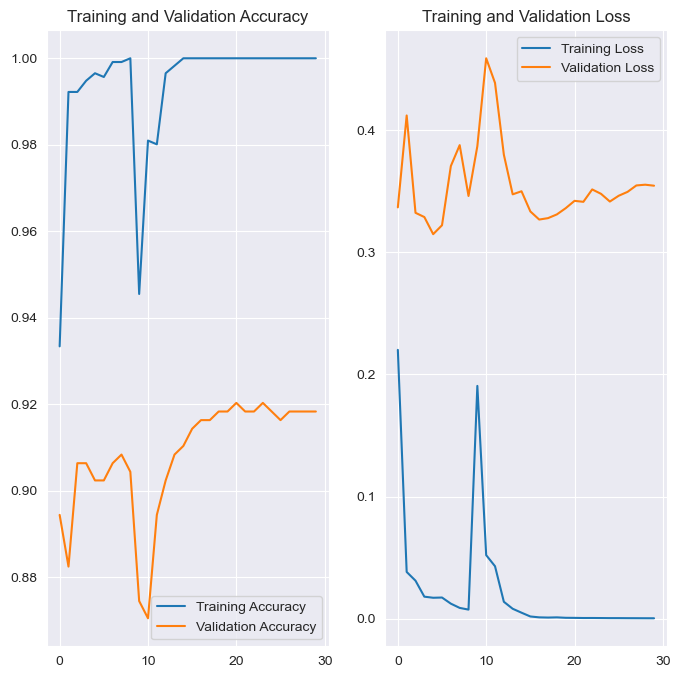

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
predicted = []
true_labels = []
dirs = list(test_dir.glob('*'))

for d in range(len(dirs)):
    dir = dirs[d]
    predicted.append([])

    for image in dir.glob('*/'):
        image = PIL.Image.open(image).resize((180, 180))
        img_array = tf.keras.utils.img_to_array(image)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        result = np.argmax(score)
        predicted[d].append(result)
        true_labels.append(d)

1/1 [==============================] - 0s 27ms/step


Accuracy

In [73]:
flat_predicted = [item for sublist in predicted for item in sublist]

print("Accuracy:", accuracy_score(true_labels, flat_predicted))

Accuracy: 0.9203187250996016


Classification Report

In [74]:
print(classification_report(true_labels, flat_predicted))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        53
           1       0.98      0.89      0.94        57
           2       0.97      0.85      0.91        41
           3       0.84      0.91      0.88        70
           4       0.85      0.94      0.89        54
           5       0.95      0.93      0.94        44
           6       0.96      0.92      0.94        52
           7       0.94      0.93      0.93        80
           8       0.85      0.90      0.88        51

    accuracy                           0.92       502
   macro avg       0.93      0.92      0.92       502
weighted avg       0.92      0.92      0.92       502



Confusion Matrix

<AxesSubplot:>

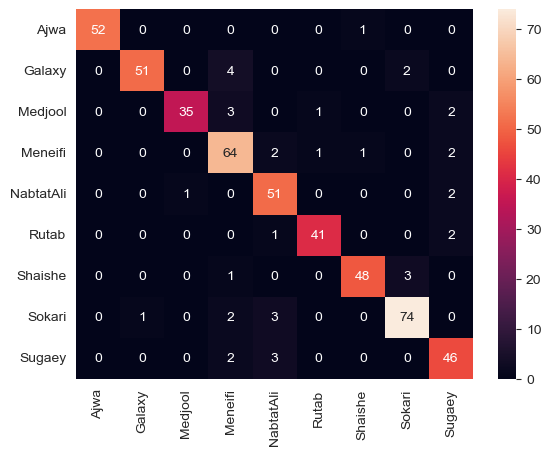

In [75]:
confusion_matrix = []
for l in range(len(predicted)):
    confusion_matrix.append([])
    for i in range(len(predicted)):
        confusion_matrix[l].append(predicted[l].count(i))

cm_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
sns.heatmap(cm_df, annot=True)